In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget


### EY analysis for the location in Golden using average photon energy (APE) binning



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvcircuit as pvc
from pvcircuit.PlotWithControls import PlotsWithControls
import ipywidgets as widgets
from scipy import constants
from scipy import integrate
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc

from IPython import display

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode

import os
import sys

from glob import glob
from datetime import datetime, timedelta
import time
from tqdm.notebook import trange
import timeit
import pickle

# set path for NREL meteorological package and import
sys.path.append("../../NREL_Meteorological")
from environmental import Spectra, Meteorological, sync
import warnings
from scipy.optimize import OptimizeWarning
from itertools import cycle
from matplotlib.lines import Line2D
import numba
import math
import pickle
from scipy.interpolate import interp1d


c:\users\rwitteck\documents\coding\python\pvcircuit_fork\pvcircuit\EY.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
warnings.simplefilter("ignore", OptimizeWarning)


Helpers


In [4]:
def wavelength_to_photonenergy(wavelength):
    return constants.h * constants.c / (wavelength * 1e-9) / constants.e


def photonenergy_to_wavelength(photonenergy):
    return constants.h * constants.c / (photonenergy * 1e-9) / constants.e


def _normalize(eqe: pd.DataFrame) -> pd.DataFrame:
    eqe_min = np.nanmin(eqe)
    eqe_max = np.nanmax(eqe)
    return (eqe - eqe_min) / (eqe_max - eqe_min)


def _eq_solve_Eg(Eg, *data):
    x, y = data
    return np.trapz(x * y, x) / np.trapz(y, x) - Eg


def _gaussian(x, a, x0, sigma):
    return 1 * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def calc_Eg_Rau(eqe, fit_gaussian=True):
    # using [1] U. Rau, B. Blank, T. C. M. Müller, and T. Kirchartz,
    # “Efficiency Potential of Photovoltaic Materials and Devices Unveiled by Detailed-Balance Analysis,”
    # Phys. Rev. Applied, vol. 7, no. 4, p. 044016, Apr. 2017, doi: 10.1103/PhysRevApplied.7.044016.
    # extended by gaussian fit

    # Define the Gaussian function
    wavelength = eqe.index.values
    y = eqe.values
    x = wavelength_to_photonenergy(wavelength)

    # convert wavelength to photon energy
    y_grad = np.abs(np.gradient(y))
    # y_grad = np.abs(np.diff(y.values, prepend=np.nan))
    # y_grad = y.diff().abs().values

    # filter tail to avoid eqe dips at end/beginning of measurement
    y_grad = y_grad[(x < (x.max() + x.min())/2)]
    y = y[(x < (x.max() + x.min())/2)]
    x = x[(x < (x.max() + x.min())/2)]
    # normalize data
    y_grad = _normalize(y_grad)
    # get the index of the maximum
    y_diff_max_idx = np.nanargmax(y_grad)
    # get the max coordinates
    x_diff_max = x[y_diff_max_idx]
    y_diff_max = y_grad[y_diff_max_idx]

    # define lower threshold
    p_ab = np.exp(-2) * y_diff_max
    thres = 0.5
    # p_ab = thres * y_diff_max
    # find the index of the low-energy side where P(a) is max(P(Eg)/2)
    a_cond = np.where((y_grad < p_ab) & (x < x_diff_max))[0]
    if len(a_cond > 0):
        a_idx = np.nanmin(a_cond)
    else:
        a_idx = len(x) - 1
    a = x[a_idx]
    p_a = y_grad[a_idx]
    # find the index of the high-energy side where P(b) is max(P(Eg)/2)
    b_idx = np.nanmax(np.where((y_grad < p_ab) & (x > x_diff_max))[0])
    b = x[b_idx]
    p_b = y_grad[b_idx]

    x_target = x[a_idx : b_idx - 1 : -1]
    y_target = y_grad[a_idx : b_idx - 1 : -1]

    if fit_gaussian:

        # initial guesses from weighted arithmetic mean and weighted sample sigma
        mean = sum(x_target * y_target) / sum(y_target)
        sigma = np.sqrt(sum(y_target * (x_target - mean) ** 2) / sum(y_target))

        fit_res = curve_fit(
            _gaussian,
            x_target,
            y_target,
            p0=[max(y_target), mean, sigma],
        )
        x_fit = np.linspace(x[b_idx], x[a_idx], 100)
        y_fit = _gaussian(x_fit, *fit_res[0])

        # fig,ax = plt.subplots(1)
        # ax.plot(x, y_grad,'.')
        # ax.plot(x_fit, y_fit)
        # ax.plot(x_target, y_target, ".r")
        # ax.plot(x_diff_max, y_diff_max, "r*")
        # ax.plot(a, p_a, "g*")
        # ax.plot(b, p_b, "b*")
        # plt.plot(x_fit - fit_res[0][1], y_fit)
        # plt.plot(x_fit, y_fit)
        # ax.set_xlim(1.1, 1.8)
        # ax.set_ylabel(r"$\frac{{\mathrm{d}}EQE}{{\mathrm{d}}E_{\nu}}$")
        # ax.set_xlabel(r"Photon energy $E_{\nu}$ [eV]")

        x_fit = x_fit[y_fit >= thres * y_fit.max()]
        y_fit = y_fit[y_fit >= thres * y_fit.max()]
        sigma = fit_res[0][2]

    else:
        fit_res = [None]
        x_fit = x_target
        y_fit = y_target
        sigma = None

    res = fsolve(_eq_solve_Eg, 1.0, args=(x_fit, y_fit))
    bandgap = res[0]
    return bandgap, sigma


def si_eg_shift(temperature, bandgap_25):
    p = [-6.47214956e-04, 1.01632828e00]
    return (p[0] * temperature + p[1]) * bandgap_25


def si_sigma_shift(temperature, sigma_25):
    p = [0.00959188, 0.76558903]
    return (p[0] * temperature + p[1])*sigma_25


def psc_eg_shift(temperature, bandgap_25):
    t_split = 32
    p = [2.59551019e-04, 9.91138163e-01]
    res = np.zeros_like(temperature)

    t_filter = temperature > t_split
    res[t_filter] = p[0] * temperature[t_filter] + p[1]
    res[~t_filter] = p[0] * t_split + p[1]
    # res = pd.Series(res, index = temperature.index)
    return res * bandgap_25


def psc_sigma_shift(temperature, sigma_25):
    p = [0.00358866, 0.90074156]
    return (p[0] * temperature + p[1])*sigma_25

def intergrate_eqe(eqe):
    path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
    # spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
    spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
    spectra_full.set_index(spectra_full.columns[0], inplace=True)

    spectra = spectra_full.reindex(eqe.index)
    if spectra.isnull().any(axis=1).any():
        spectra = spectra.reindex(index=eqe.index).interpolate(method="index")

    # jsc = (
    #     eqe.apply(lambda x: np.trapz(y=x * spectra["global"] / qe._wavelength_to_photonenergy(eqe.index), x=eqe.index)) / 10
    # )
    jsc = np.trapz(y=eqe.values * spectra["global"] / wavelength_to_photonenergy(eqe.index), x=eqe.index) / 10
    
    
    return jsc
    si_fit = np.polyfit(temperature_silicon, jsc[1:], 1)

    temps = np.linspace(min(temperature_silicon), max(temperature_silicon), 50)
    jsc_fit = np.polyval(si_fit, temps)

    fig, ax = plt.subplots(1)
    ax.plot(temperature_silicon, jsc[1:], "*", temps, jsc_fit)

# @numba.jit()
def shift_eqe(eqe_ref, bandgap_25, sigma_25, bandgaps, sigmas, spectra):

    eqe = eqe_ref.values
    lam = eqe_ref.index.values
    Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    # abs = 1 / 2 * erfc((bandgap_25 - Ey) / (sigma_25 * np.sqrt(2)))

    lam_eqe_saturation_idx = np.argmax(eqe * lam)
    eqe_saturation = eqe[lam_eqe_saturation_idx]
    # lam_eqe_saturation = lam[lam_eqe_saturation_idx]

    # jscs = []
    # # fig,ax = plt.subplots()
    # for i, col in enumerate(bandgaps):
    #     # print(qe_data.temperature)
    #     spec = spectra.iloc[i][lam]
    #     bandgap = bandgaps[i]
    #     sigma = sigmas[i]
    #     abs = 1 / 2 * erfc((bandgap - Ey) / (sigma * np.sqrt(2))) * eqe_saturation
    #     eqe_filter = lam > photonenergy_to_wavelength(bandgap + 2*sigma)
    #     eqe_new = np.concatenate([eqe[~eqe_filter],abs[eqe_filter]])
    #     # ax.plot(eqe_new)
    #     jscs.append(np.trapz(y = eqe_new * spec / wavelength_to_photonenergy(spec.index), x = spec.index) / 10)
    
    if len(spectra) > 1:
        spec_interp_func = interp1d(spectra.index, spectra,axis=0)

        spectra_interp = pd.DataFrame(spec_interp_func(spectra.index.astype(np.float64)).astype(np.float64), index = spectra.index.astype(np.float64))

    else:
        spectra_interp = spectra.T
        
    bandgaps_arr = np.tile(bandgaps, [len(Ey), 1])
    sigmas_arr = np.tile(sigmas, [len(Ey), 1])
    erfc_arr = (bandgaps_arr - Ey.reshape(-1,1)) / (sigmas_arr * np.sqrt(2))
    vec_erfc = np.vectorize(erfc)
    abs_arr = vec_erfc(erfc_arr) * 0.5 * eqe_saturation
    eqe_filter = np.tile(lam,[len(bandgaps),1]).T > photonenergy_to_wavelength(bandgaps_arr + 2*sigmas_arr)
    eqe_new_arr = np.tile(eqe,[len(bandgaps),1]).T    
    eqe_new_arr = eqe_new_arr * ~eqe_filter + abs_arr * eqe_filter
    # jscs = np.trapz(y = eqe_new_arr * spectra[lam].values.T  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    jscs = np.trapz(y = eqe_new_arr * spectra_interp.loc[lam].values.reshape(-1,1)  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    
    # print(f"check jscs = {all(jscs_arr == np.array(jscs))}")
    
    return jscs
    


Some notebook settings

In [5]:
t_elaps = None
t_elapsMP = None

squeeze_day_to_one_day = True # squeezes the meteo data into one day to allow plot comparison in one day
results = None

Load the meteorological data

In [6]:
def get_meteo(date_start, date_end, resampler):
    
    # date_start = datetime(2022, 6, 15, 0, 0, 0)  # sunny day
    # date_end = date_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    meteo_data = Meteorological.get_midc_environmental(date_start, date_end)
    # spectra_class = Spectra.get_srrl_wiser_global_track(date_start, date_end)
    spectra_class = Spectra.get_srrl_solarsim_direct_normal(date_start, date_end)
    
    

    # resample
    spectra_resampled = spectra_class.spectra.resample(resampler).median()
    meteo_resampled = meteo_data.data.resample(resampler).median()

    spectra_sync, meteo_sync = sync(spectra_resampled, meteo_resampled)

    # remove nan
    nan_filter = spectra_sync.isna().any(axis=1) | meteo_sync.isna().any(axis=1)
    spectra_sync = spectra_sync[~nan_filter]
    meteo_sync = meteo_sync[~nan_filter]
    
    #remove negative spectral data
    spec_filter = (spectra_sync<-1).any(axis=1)
    spectra_sync = spectra_sync[~spec_filter]
    meteo_sync = meteo_sync[~spec_filter]

    # if squeeze_days_to_one_day:
    #     meteo_data.data.index = meteo_data.data.index.map(lambda dt: dt.replace(day=1))
    
    # import TMY data of meteo_spectra
    meteo_spectra = pvc.Meteo(
        wavelength=spectra_sync.columns.astype(np.int32),
        spectra=spectra_sync,
        ambient_temperature=meteo_sync["Deck Dry Bulb Temp [deg C]"],
        wind=meteo_sync["Avg Wind Speed @ 19ft [m/s]"],
        daytime=spectra_sync.index,
    )
    return meteo_spectra


Hard coded scenarios for cell data

In [7]:
def get_jv_params(fp_psk_jv, fp_si_jv, plot_fits:bool=False):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

    psk_data = pd.read_csv(os.path.join(path, fp_psk_jv))
    A = 1  # [cm^2]
    TC = 25  # [degC]

    # Measured terminal voltage.
    voltage = psk_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = psk_data["i"].to_numpy(np.double) / 1000 * A  # [A/cm^2]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
        voltage, current
    )
    ilim = 0.6
    while psc_params[2] < 0:
        ilim -=0.01        
        # fit iv
        psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
            voltage, current, ilim=ilim
        )
        
    if plot_fits:
        fit = singlediode(*psc_params, ivcurve_pnts=30)
        fig,ax = plt.subplots()
        ax.plot(voltage,current,"k*",label="psc-data")
        ax.plot(fit["v"],fit["i"],"k--",label="psc-fit")
        
        
    si_data = pd.read_csv(os.path.join(path, fp_si_jv))
    # Measured terminal voltage.
    voltage = si_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = si_data["i"].to_numpy(np.double) / 1000 * A  # [A]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voc_guess_idx
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current
    )
    ilim = 0.6
    while si_params[2] < 0:
        ilim -=0.01        
        # fit iv
        si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
            voltage, current, ilim=ilim
        )
    
    if plot_fits:
        fit = singlediode(*si_params, ivcurve_pnts=30)
        ax.plot(voltage,current,"rx",label="Si-data")
        ax.plot(fit["v"],fit["i"], "r--",label="Si-fit")
        
    return psc_params, si_params

In [8]:
def get_tandem_eqe(fp_psk_eqe, fp_psk_trans, fp_si_eqe, psc_params, si_params):
    
    # get the Silicon paramters
    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params
    
    A = 1  # [cm^2]
    TC = 25  # [degC]
    
    reader_settings = {"index_col": 0, "usecols": [0, 1]}
    df_psk_eqe = pd.read_excel(fp_psk_eqe, **reader_settings).dropna().squeeze("columns")
    df_psk_trans = pd.read_csv(fp_psk_trans, **reader_settings).dropna().squeeze("columns")
    df_si_eqe = pd.read_excel(fp_si_eqe, **reader_settings).dropna().squeeze("columns")

    df_psk_trans = None
    if df_psk_trans is None:
        df_psk_trans = 1 - _normalize(df_psk_eqe)
        
    # in case values are percentages
    if any(df_psk_eqe.values > 1):
        df_psk_eqe = df_psk_eqe.div(100)
    if any(df_psk_trans.values > 1):
        df_psk_trans = df_psk_trans.div(100)
    if any(df_si_eqe.values > 1):
        df_si_eqe = df_si_eqe.div(100)

    # # round in case wavelength has many floating points
    df_psk_eqe.index = np.round(df_psk_eqe.index.astype(np.double), 1)
    df_psk_trans.index = np.round(df_psk_trans.index.astype(np.double), 1)
    df_si_eqe.index = np.round(df_si_eqe.index.astype(np.double), 1)

    # integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
    eqe_scaler = psc_isc / A * 1e3 / intergrate_eqe(df_psk_eqe)
    df_psk_eqe = df_psk_eqe * eqe_scaler

    eqe_scaler = si_isc / A * 1e3 / intergrate_eqe(df_si_eqe)
    df_si_eqe = df_si_eqe * eqe_scaler

    # interpolate with eqe's superseding transmission wavelengths
    comb_lam = df_psk_eqe.index.union(df_si_eqe.index)
    df_psk_eqe_interp = df_psk_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    df_psk_trans_interp = df_psk_trans.reindex(index=comb_lam).interpolate(method="index")
    df_si_eqe_interp = df_si_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    
    
    eqe_max_idx = df_psk_eqe_interp.idxmax()
    filter_idx = (df_psk_eqe_interp.values < 0.01) & (df_psk_trans_interp.index.values > eqe_max_idx)
    df_psk_trans_interp[filter_idx] = 1

    df_si_eqe_filtered = df_psk_trans_interp * df_si_eqe_interp

    # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    lam_cut_psc = photonenergy_to_wavelength(eg_psc + 2 * sigma_psc)

    df_si_eqe_filtered[df_psk_eqe_interp.index <= lam_cut_psc] = 0

    # commbine Psk and filter EQE
    df_tandem_eqe = pd.concat([df_psk_eqe_interp, df_si_eqe_filtered], axis=1)
    df_tandem_eqe.columns = ["Psk", "Si"]
    
    
    return df_tandem_eqe, df_si_eqe_interp


In [9]:
def get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si):

    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params


    jo_scale = 1000
    A = 1  # [cm^2]
    TC = 25  # [degC]

    psc_jsc = psc_isc / A  # [A/cm^2]
    psc_jo = psc_io / A
    psc_n = psc_nNsVth / pvc.junction.Vth(TC)
    psc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_psc)
    psc_joratio = jo_scale * psc_jo / (psc_jdb * jo_scale) ** (1.0 / psc_n)
    psc_joratio = 300

    psc_rser = psc_rs * A
    psc_gsh = 1 / (psc_rsh * A)

    si_jsc = si_isc / A  # [A/cm^2]
    si_jo = si_io / A
    si_n = si_nNsVth / pvc.junction.Vth(TC)
    si_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_si)
    si_joratio = jo_scale * si_jo / (si_jdb * jo_scale) ** (1.0 / si_n)
    
    si_jsc = intergrate_eqe(df_si_eqe_filtered) / 1e3
    

    si_rser = si_rs * A
    si_gsh = 1 / (si_rsh * A)

    dev3T = pvc.Tandem3T()
    dev3T.set(name="PskSidev3T", Rz=0)
    dev3T.top.set(Eg=eg_psc, J0ratio=[psc_joratio], Jext=psc_jsc, Gsh=psc_gsh, Rser=psc_rser, n=[psc_n], beta = 0, JLC = 0)
    dev3T.bot.set(Eg=eg_si, J0ratio=[si_joratio], Jext=si_jsc, Gsh=si_gsh, Rser=si_rser, n=[si_n], beta = 0, JLC = 0)
    return dev3T

Funtions for the APE binning

In [10]:
def get_ape_df(meteo_spectra):
    ape_dataframe = pd.DataFrame(
        {"timestamps": meteo_spectra.spectra.index, "SpecPower": meteo_spectra.SpecPower, "TempCell": meteo_spectra.TempCell.values}, index=meteo_spectra.average_photon_energy
    )
    return ape_dataframe

def ape_binning(nr_of_ape_bins, ape_dataframe, *, plot_binning=False):
    
    ape_dataframe_apesorted = ape_dataframe.sort_index()
    ape_dataframe_apesorted["powerCumSum"] = ape_dataframe_apesorted["SpecPower"].cumsum()
    total_power = ape_dataframe_apesorted["powerCumSum"].iloc[-1]
    bin_power = total_power / nr_of_ape_bins

    if plot_binning:
        ax = ape_dataframe_apesorted["powerCumSum"].plot()
    ape_bin_edges = np.zeros(nr_of_ape_bins + 1)
    ape_bin_mids = np.zeros(nr_of_ape_bins)
    ape_bin_counts = np.zeros(nr_of_ape_bins)
    ape_bin_edges[0] = ape_dataframe.index.min() * 0.99
    for ape_bin in range(1, nr_of_ape_bins + 1):
        max_idx = ape_dataframe_apesorted["powerCumSum"][ape_dataframe_apesorted["powerCumSum"] <= ape_bin * bin_power].dropna().index[-1]
        ape_bin_edges[ape_bin] = max_idx
        ape_bin_mids[ape_bin - 1] = (ape_bin_edges[ape_bin - 1] + ape_bin_edges[ape_bin]) / 2
        
        ape_bin_counts[ape_bin - 1] = len(ape_dataframe_apesorted[(ape_dataframe_apesorted.index > ape_bin_edges[ape_bin - 1]) & (ape_dataframe_apesorted.index <= ape_bin_edges[ape_bin])])
        
        if plot_binning:
            ax.plot([0, max_idx], [ape_bin * bin_power, ape_bin * bin_power], "r--")
            ax.plot([max_idx, max_idx], [0 * bin_power, ape_bin * bin_power], "r--")

    if plot_binning:
        ax.set_xlabel("Average photon energy $APE$ [eV]")
        ax.set_ylabel("Cumulative irradiance $E$ [W m$^{-2}$]")
        
    return ape_bin_mids, ape_bin_edges, ape_bin_counts

Load cell parameters from IV measurement

In [11]:
path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

datalist = glob(path + "**" + os.path.sep +"*")
# print(*(f"{i:>2} --> {os.path.basename(x)}" for i, x in enumerate(datalist)), sep="\n")

fp_psk_eqe = {
    1.25 : [file for file in datalist if "1.25" in file and "_QE" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_QE" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_QE" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_QE" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_QE" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_QE" in file][0]
}

fp_psk_trans = {
    1.25 : [file for file in datalist if "1.53" in file and "_tr" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.68 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.75 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.80 : [file for file in datalist if "1.70" in file and "_tr" in file][0]
}

fp_psk_jv = {
    1.25 : [file for file in datalist if "1.25" in file and "_JV" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_JV" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_JV" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_JV" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_JV" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_JV" in file][0]
}


# file_psk_trans = "Pvsk0111D_1.7sb_tr.csv"
fp_si_eqe = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_QE.xlsx" in file][0] 
fp_si_jv = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_JV.csv" in file][0]




16.835315096608326

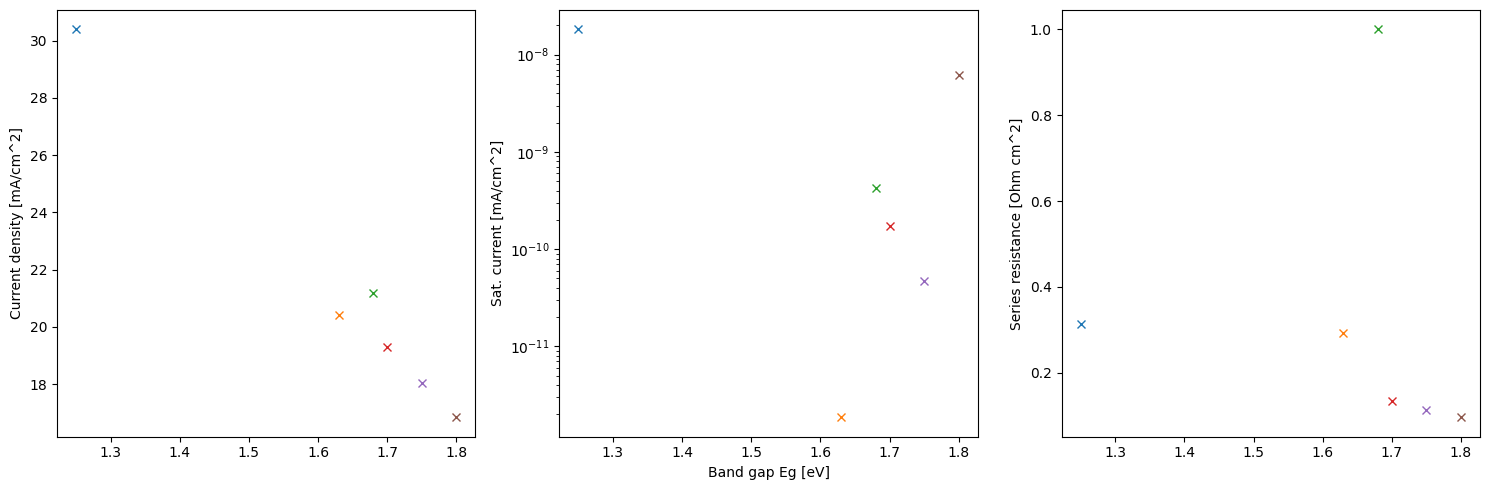

In [12]:
fig,ax = plt.subplots(1,3,sharex=True,figsize=(15, 5))
for eg in fp_psk_eqe.keys():
    
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    ax[0].plot(eg,psc_params[0]*1e3,"x")
    ax[1].plot(eg,psc_params[1]*1e3,"x")
    ax[2].plot(eg,psc_params[2],"x")
ax[1].set_yscale("log")

ax[1].set_xlabel("Band gap Eg [eV]")
ax[0].set_ylabel("Current density [mA/cm^2]")
ax[1].set_ylabel("Sat. current [mA/cm^2]")
ax[2].set_ylabel("Series resistance [Ohm cm^2]")
plt.tight_layout()
psc_params[0] * 1e3

Currently assumes average J0 ratio for all perovskite cells

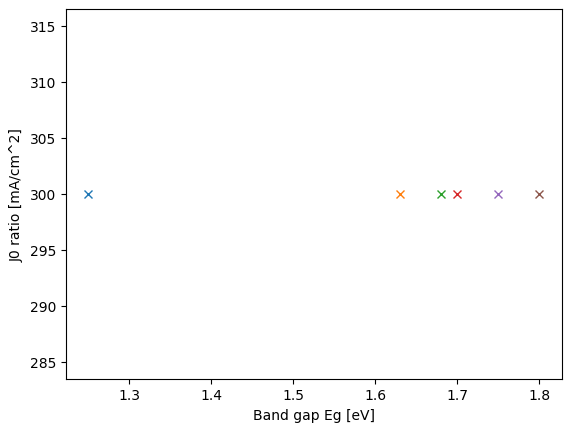

In [13]:
fig,ax = plt.subplots(1)

for eg in fp_psk_eqe.keys():
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_spectra.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    ax.plot(eg,dev3T.top.J0ratio,"x")
    ax.set_xlabel("Band gap Eg [eV]")
    ax.set_ylabel("J0 ratio [mA/cm^2]")

# Load meteorological data <b>
 
currently uses pickle for faster reloading

In [14]:
date_start = datetime(2021, 11, 1, 0, 0, 0)
date_end = datetime(2022, 11, 1, 0, 0, 0) - pd.Timedelta(seconds=1)

# meteo_spectra = get_meteo(date_start, date_end, "1T")

# with open("meteo_year.p", "wb") as fout:
#     pickle.dump(meteo_spectra,fout)
    
## Load global meteorological data from 01.11.2021 until 31.10.2022
with open("meteo_year.p", "rb") as fin:
    meteo_spectra = pickle.load(fin)

## Load direct meteorological data from 01.11.2021 until 31.10.2022
# with open("direct_meteo_year.p", "rb") as fin:
#     meteo_spectra = pickle.load(fin)



Get environmental irradiance data

In [15]:
meteo_data = Meteorological.get_midc_environmental(date_start, date_end)


loading environmental from internal from 2021-11-01 00:00:00 to 2022-05-09 23:59:59
loading environmental from internal from 2022-05-10 00:00:00 to 2022-10-31 23:59:59


Filter spectral data by irradiance sensor data

In [16]:
# define metrics to compare deviations betweens integrated spectra and irradiance sensor measurements
def calc_euclidean_dev(actual, predic):
    return np.sqrt(np.sum((actual - predic) ** 2))


def calc_percent_dev(actual, predic):
    # return np.mean(np.abs((actual - predic) / actual))
    return np.nanmedian(np.abs((actual - predic) / actual))


def calc_cosine_dev(actual, predic):
    return np.abs(np.nansum(actual * predic) / (np.sqrt(np.nansum(np.square(actual))) * np.sqrt(np.nansum(np.square(predic)))))


def calc_chebi_dev(actual, predic):
    n = len(actual)
    diff = np.abs(actual - predic)
    diff_sort = np.sort(diff)
    return np.nansum(diff_sort[: n // 5 : -1])


def confidence_filter(x,y, level):
    p = np.polyfit(x,y,1)
    yh = p[0] * x + p[1] 
    
    y_err = np.sum((y-yh)**2)/len(y)
    
# set the spectra
# spectra_meteo_sync, meteo_sync = spectra.meteo.align(meteo_data.data, join="inner", axis=0)
_, meteo_sync = sync(meteo_spectra.spectra, meteo_data.data)

integrated_spectra = np.trapz(y=meteo_spectra.spectra, x=meteo_spectra.wavelength)

# compute sum squared residuals for all irradiance meteo data and comapre with integrated spectra
deviation = []
eucl_dev = []
perc_dev = []
cheby_dev = []
cols = [x for x in meteo_data.data.columns if "W/m" in x]
for col in cols:
    eucl_dev.append(calc_euclidean_dev(integrated_spectra, meteo_sync[col]))
    perc_dev.append(calc_percent_dev(integrated_spectra, meteo_sync[col]))
    cheby_dev.append(calc_chebi_dev(integrated_spectra, meteo_sync[col]))


Best matching sensor is: Global Normal CMP22 [W/m^2]


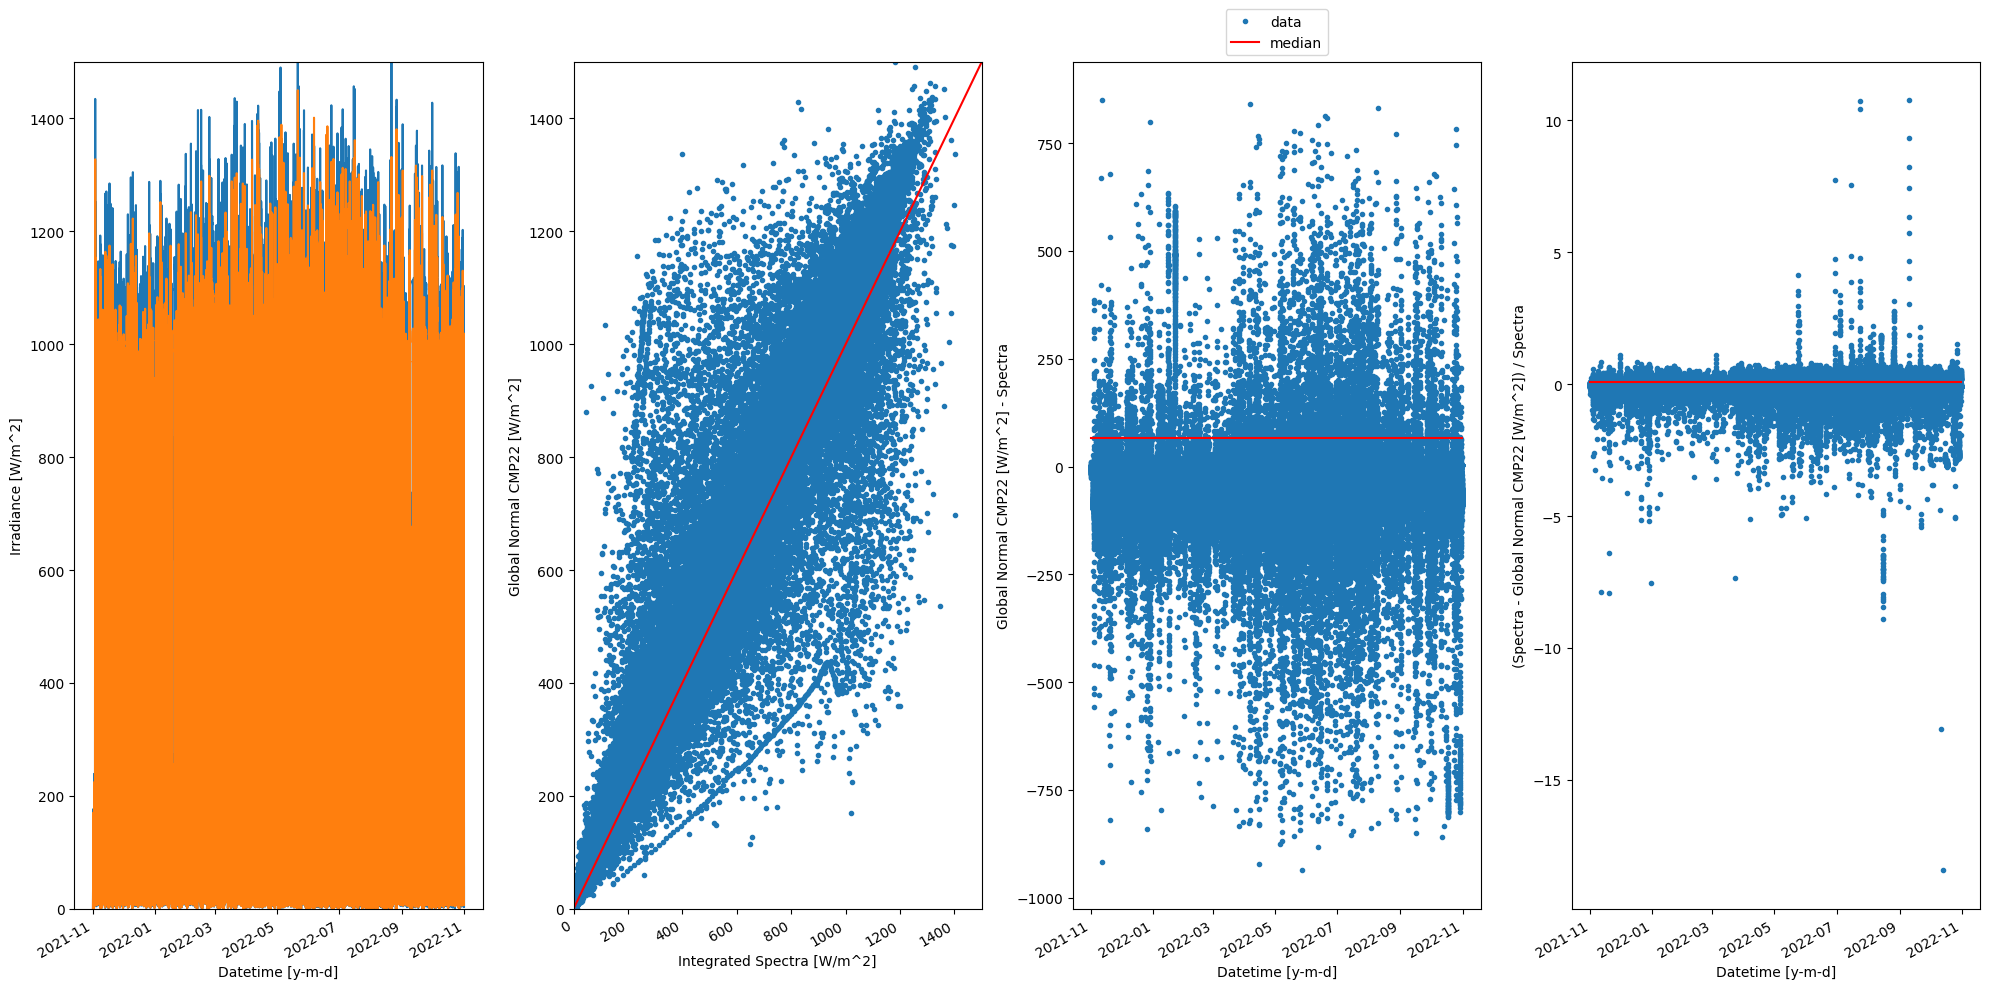

In [17]:
df_deviations = pd.DataFrame({'sensor':cols,"Euclid": eucl_dev, "Percentage": perc_dev, "Chebychev": cheby_dev})
df_rank = df_deviations.iloc[:,1:].rank() 
df_rank['median'] = df_rank.median(axis=1)
df_rank_sort = df_rank.sort_values('median')

idx = df_rank_sort.index[0]
fig, ax = plt.subplots(1, 4, figsize=[20, 10])

ax[0].plot(meteo_sync[cols[idx]], label=cols[idx])
ax[0].plot(meteo_spectra.spectra.index, integrated_spectra, label=meteo_spectra.spectra)
ax[0].set_ylim(0, 1500)
# ax[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax[0].set_xlabel("Datetime [y-m-d]")
ax[0].set_ylabel("Irradiance [W/m^2]")

ax[1].plot(integrated_spectra, meteo_sync[cols[idx]], ".", label=f"{cols[idx]} | Spectra")
ax[1].plot([0, 1500], [0, 1500], "r-")
ax[1].set_xlim(0, 1500)
ax[1].set_ylim(0, 1500)
# ax[1].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax[1].set_xlabel(f"Integrated Spectra [W/m^2]")
ax[1].set_ylabel(f"{cols[idx]}")

diff = integrated_spectra - meteo_sync[cols[idx]]
ax[2].plot(diff, ".", label=f"{cols[idx]} - Spectra")
ax[2].plot(
    [meteo_spectra.spectra.index[0], meteo_spectra.spectra.index[-1]],
    [np.nanmedian(np.abs(diff)), np.nanmedian(np.abs(diff))],
    "r-",
    label=f"{cols[idx]} - Spectra",
)
# ax[2].plot(meteo_sync[cols[idx]], label=cols[idx])
# ax[2].plot(meteo_sync[cols[idx2]], label=cols[idx2])

ax[2].legend(['data', 'median'], loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax[2].set_xlabel("Datetime [y-m-d]")
ax[2].set_ylabel(f"{cols[idx]} - Spectra")

# idx2 = ssr.index(ssr_sort[1])
# ax[3].plot(meteo_sync[cols[idx]] - meteo_sync[cols[idx2]], label=f"{cols[idx]} - {cols[idx2]}")
# ax[3].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0))

frac = (integrated_spectra - meteo_sync[cols[idx]]) / integrated_spectra
ax[3].plot(frac, ".", label=f"(Spectra - {cols[idx]}) / Spectra")
ax[3].plot(
    [meteo_spectra.spectra.index[0], meteo_spectra.spectra.index[-1]],
    [np.nanmedian(np.abs(frac)), np.nanmedian(np.abs(frac))],
    "r-",
    label=f"{cols[idx]} - Spectra",
)
ax[3].set_xlabel("Datetime [y-m-d]")
ax[3].set_ylabel(f"(Spectra - {cols[idx]}) / Spectra")

fig.autofmt_xdate()
plt.tight_layout()
print(f"Best matching sensor is: {cols[idx]}")

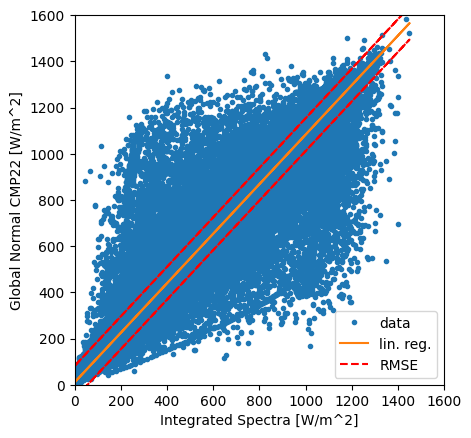

In [18]:
# from scipy.stats import t
def confidence_filter(x,y, level):
    n = len(y)
    p = np.polyfit(x,y,1)
    yh = p[0] * x + p[1] 
    
    y_err = np.sum((y-yh)**2)/n
    # s_res = np.sqrt(np.sum((y-yh)**2)/(n-2))
    # ssx = np.sum((x - x.mean())**2)
    # se = s_res * np.sqrt(1/n + (x - np.mean(x)) / ssx)
    # dof = n-1 
    # t_crit = np.abs(t.ppf((1-level)/2,dof))
    # y_err = np.std(np.array(y)-yh) * np.sqrt(1/n + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    # ci = se * t_crit
    
    ci = 1 * np.sqrt(y_err)
    
    plt.plot(x,y,".")
    plt.plot(x,yh)
    plt.plot(x,yh + ci,"r--")
    plt.plot(x,yh - ci,"r--")

confidence_filter(integrated_spectra, meteo_sync[cols[idx]], 0.95)

ax = plt.gca()
ax.set_xlabel(f"Integrated Spectra [W/m^2]")
ax.set_ylabel(f"{cols[idx]}")
ax.set_box_aspect(1)
ax.set_xlim(0,1600)
ax.set_ylim(0,1600)
ax.legend(['data', 'lin. reg.', 'RMSE'])

Determine average photon energy (APE) and Filter irrelevant energies


In [19]:
meteo_spectra.calc_ape()
meteo_spectra_filtered = meteo_spectra.filter_ape(min_ape = 0, max_ape = 4).filter_spectra(min_spectra = 1e-3)

Best matching sensor is: Global Normal LI-200R [W/m^2]


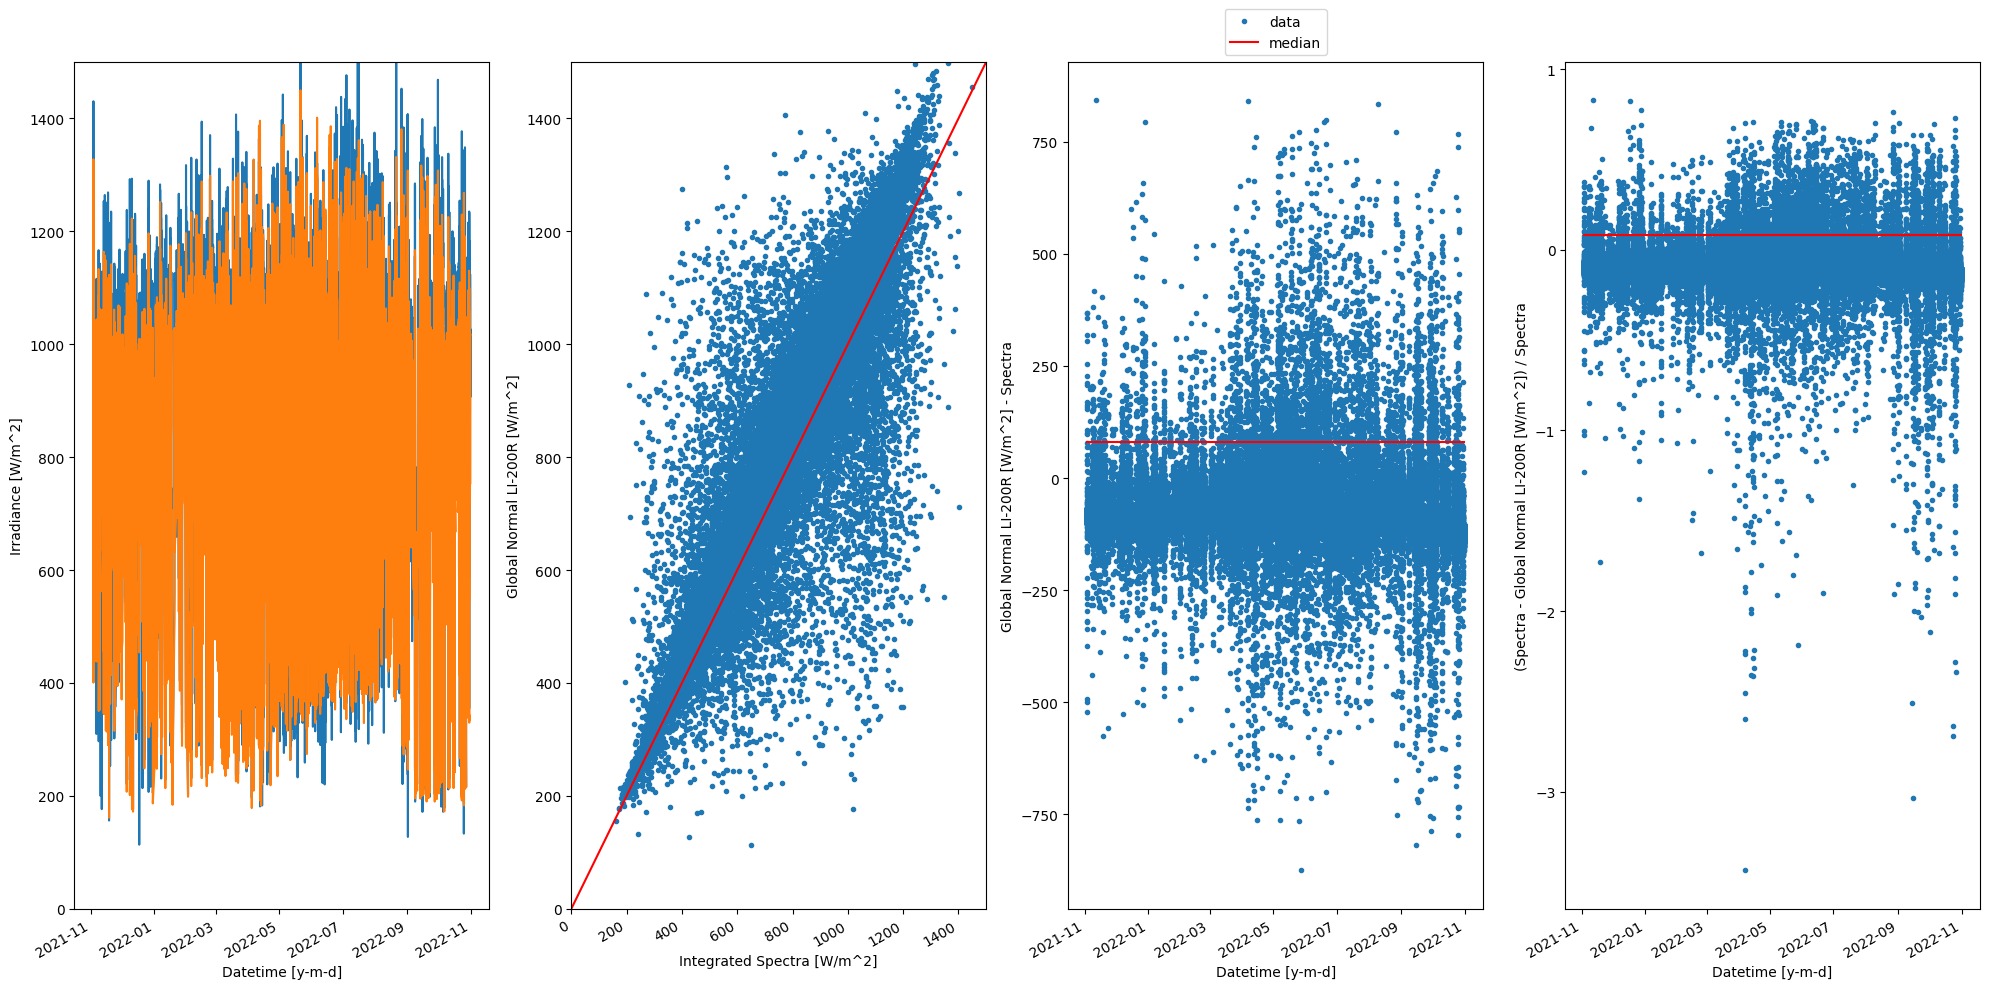

In [20]:
# set the spectra
# spectra_meteo_sync, meteo_sync = spectra.meteo.align(meteo_data.data, join="inner", axis=0)
_, meteo_sync = sync(meteo_spectra_filtered.spectra, meteo_data.data)

integrated_spectra = meteo_spectra_filtered.SpecPower

# compute sum squared residuals for all irradiance meteo data and comapre with integrated spectra
deviation = []
eucl_dev = []
perc_dev = []
cheby_dev = []
cols = [x for x in meteo_data.data.columns if "W/m" in x]
for col in cols:
    eucl_dev.append(calc_euclidean_dev(meteo_spectra_filtered.SpecPower, meteo_sync[col]))
    perc_dev.append(calc_percent_dev(meteo_spectra_filtered.SpecPower, meteo_sync[col]))
    cheby_dev.append(calc_chebi_dev(meteo_spectra_filtered.SpecPower, meteo_sync[col]))


df_deviations = pd.DataFrame({'sensor':cols,"Euclid": eucl_dev, "Percentage": perc_dev, "Chebychev": cheby_dev})
df_rank = df_deviations.iloc[:,1:].rank() 
df_rank['median'] = df_rank.median(axis=1)
df_rank_sort = df_rank.sort_values('median')

idx = df_rank_sort.index[0]
fig, ax = plt.subplots(1, 4, figsize=[20, 10])

ax[0].plot(meteo_sync[cols[idx]], label=cols[idx])
ax[0].plot(meteo_spectra_filtered.spectra.index, meteo_spectra_filtered.SpecPower, label=meteo_spectra.spectra)
ax[0].set_ylim(0, 1500)
# ax[0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax[0].set_xlabel("Datetime [y-m-d]")
ax[0].set_ylabel("Irradiance [W/m^2]")

ax[1].plot(meteo_spectra_filtered.SpecPower, meteo_sync[cols[idx]], ".", label=f"{cols[idx]} | Spectra")
ax[1].plot([0, 1500], [0, 1500], "r-")
ax[1].set_xlim(0, 1500)
ax[1].set_ylim(0, 1500)
# ax[1].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax[1].set_xlabel(f"Integrated Spectra [W/m^2]")
ax[1].set_ylabel(f"{cols[idx]}")

diff = meteo_spectra_filtered.SpecPower - meteo_sync[cols[idx]]
ax[2].plot(diff, ".", label=f"{cols[idx]} - Spectra")
ax[2].plot(
    [meteo_spectra_filtered.spectra.index[0], meteo_spectra_filtered.spectra.index[-1]],
    [np.nanmedian(np.abs(diff)), np.nanmedian(np.abs(diff))],
    "r-",
    label=f"{cols[idx]} - Spectra",
)
# ax[2].plot(meteo_sync[cols[idx]], label=cols[idx])
# ax[2].plot(meteo_sync[cols[idx2]], label=cols[idx2])

ax[2].legend(['data', 'median'], loc="lower center", bbox_to_anchor=(0.5, 1.0))
ax[2].set_xlabel("Datetime [y-m-d]")
ax[2].set_ylabel(f"{cols[idx]} - Spectra")

# idx2 = ssr.index(ssr_sort[1])
# ax[3].plot(meteo_sync[cols[idx]] - meteo_sync[cols[idx2]], label=f"{cols[idx]} - {cols[idx2]}")
# ax[3].legend(loc="lower center", bbox_to_anchor=(0.5, 1.0))

frac = (meteo_spectra_filtered.SpecPower - meteo_sync[cols[idx]]) / meteo_spectra_filtered.SpecPower
ax[3].plot(frac, ".", label=f"(Spectra - {cols[idx]}) / Spectra")
ax[3].plot(
    [meteo_spectra_filtered.spectra.index[0], meteo_spectra_filtered.spectra.index[-1]],
    [np.nanmedian(np.abs(frac)), np.nanmedian(np.abs(frac))],
    "r-",
    label=f"{cols[idx]} - Spectra",
)
ax[3].set_xlabel("Datetime [y-m-d]")
ax[3].set_ylabel(f"(Spectra - {cols[idx]}) / Spectra")

fig.autofmt_xdate()
plt.tight_layout()
print(f"Best matching sensor is: {cols[idx]}")

Integrate currrents from spectra and EQE

In [21]:
currents = pd.DataFrame(
    np.zeros([meteo_spectra_filtered.spectra.shape[0], len(fp_psk_eqe.keys()) * 2]),
    index=meteo_spectra_filtered.spectra.index,
    columns=[
        f"{jsc}_{eg}"
        for jsc, eg in zip(
            ["Jsctop", "Jscbot"] * len(list(fp_psk_eqe.keys())), [eg for eg in list(fp_psk_eqe.keys()) for _ in range(2)]
        )
    ],
)

for idx, eg in enumerate(fp_psk_eqe.keys()):

    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    # dev3T.top.set(Rser=Rz)

    # spectra = wiser_global_horizontal.spectra.loc[date_plot]
    spectra_T = meteo_spectra_filtered.spectra.T
    spectra_T.index = meteo_spectra_filtered.wavelength

    spectra_interp = spectra_T.reindex(index=df_psk_eqe_interp.index).interpolate(method="index")

    # spectra = wiser_global_horizontal.spectra.loc[date_start:date_end].T
    Jsc_top = np.trapz(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1, 1)
        * spectra_interp.values
        * df_psk_eqe_interp.values.reshape(-1, 1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )
    Jsc_bottom = np.trapz(
        constants.e / constants.h / constants.c * spectra_interp.index.values.reshape(-1, 1) * spectra_interp.values
        # * df_si_eqe_interp.values
        * df_si_eqe_filtered.values.reshape(-1, 1) * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )

    currents.iloc[:, 2 * idx] = Jsc_top
    currents.iloc[:, 2 * idx + 1] = Jsc_bottom

Bin APE

In [22]:
nr_of_ape_bins = 15
nr_of_temp_bins = 1

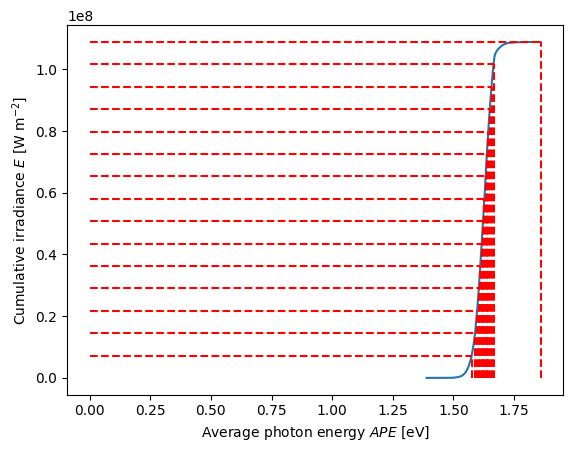

In [23]:
ape_dataframe = get_ape_df(meteo_spectra_filtered)
ape_bin_mids, ape_bin_edges, ape_bin_counts = ape_binning(nr_of_ape_bins=nr_of_ape_bins,ape_dataframe=ape_dataframe,plot_binning=True)

Do the binning by cumulative energy

Loop over all APE bins and average the spectra. Assign each spectra a time delta. Multiply the correspondig spectrum with the time delta. Sum over all spectra and divide by the total time in that bin.

Text(0, 0.5, 'Spectral irradiance $E$ [W m$^{-2}$ nm$^{-1}$]')

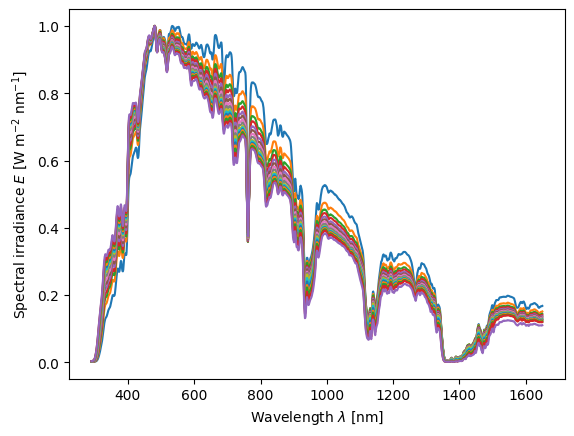

In [24]:

ape_spectra = pd.DataFrame(np.zeros([len(ape_bin_mids), len(meteo_spectra_filtered.wavelength)]), index = ape_bin_mids, columns = meteo_spectra_filtered.wavelength)
irradiance = []
total_bin_energy = []
for idx_ape, ape_bin in enumerate(ape_bin_mids):
    # get a mask for the current APE bin range
    ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
    # filter the spectra with this mask to get all spectra for this APE range
    bin_spectra = meteo_spectra_filtered.spectra[ape_bin_mask]
    
    # get the timestamps and determine time deltas for each spectra
    bin_times = bin_spectra.index
    bin_time_deltas = bin_times.to_series().diff().astype(np.int64)/1e9
    _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
    # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
    bin_time_deltas[day_idx] = 60
    
    # set all to 60s
    bin_time_deltas[:] = 60
    
    # weight all spectra with the time and divide by total time to get averaged spectra
    ape_spectra.iloc[idx_ape,:] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1,1)) / np.sum(bin_time_deltas)
    
    # weight al spectra with the energy and divide by total energy to get averaged spectra
    bin_irradiances = pd.Series(np.trapz(x=bin_spectra.columns.astype(np.float32), y=bin_spectra), index = bin_spectra.index)
    bin_energies = bin_irradiances * bin_time_deltas
    total_bin_energy.append(np.sum(bin_energies))
    
    ape_spectra.iloc[idx_ape,:] = np.sum(bin_spectra * bin_energies.values.reshape(-1,1)) / np.sum(bin_energies)
    
    irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape,:]))
    
    # Plot BIN irradiances
    # plt.figure()
    # plt.hist(bin_irradiances,30)
    
    # plt.figure()
    # plt.plot(bin_irradiances,".")
    # average_irradiance = np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape,:])
    # plt.plot([bin_irradiances.index.min(), bin_irradiances.index.max()], [average_irradiance,average_irradiance],"r-")
    
    # bin temperature in each bin
    bin_temps = ape_dataframe["TempCell"][ape_bin_mask]
    # print(f"Bin {bin_mids[idx]:.2f} varies from {bin_temps.min():.2f} to {bin_temps.max():.2f} with mean {bin_temps.mean():.2f} and median {bin_temps.median():.2f} - bin cont {bin_counts[idx]} / {len(bin_temps)}")
(ape_spectra.T/ape_spectra.max(axis=1)).plot()
# ape_spectra.T.plot()

ax =plt.gca()
ax.get_legend().remove()
if len(ape_bin_mids) < 7:
    ax.legend([f"{ape:.2f} eV" for ape in ape_bin_mids])
ax.set_xlabel("Wavelength $\\lambda$ [nm]")
ax.set_ylabel("Spectral irradiance $E$ [W m$^{-2}$ nm$^{-1}$]")


In [25]:
# plt.plot(total_bin_energy,".")
# np.sum(total_bin_energy) / (ape_dataframe_apesorted["powerCumSum"].values[-1] * 60)


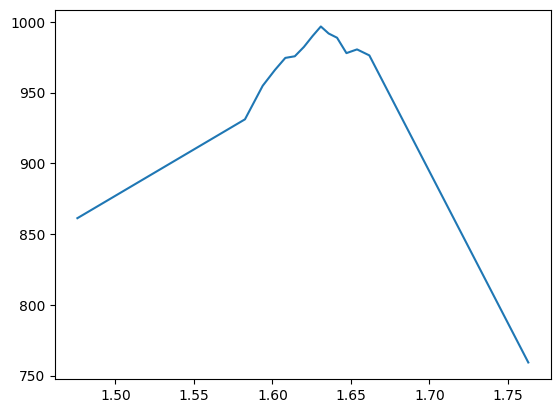

In [26]:
plt.plot(ape_spectra.index,irradiance)

In [51]:
egs = list(fp_psk_eqe.keys())

cols = [
    "Eg",
    "totalTime",
    "binCount",
    "ape",
    "temp",
    "ape_bin_width",
    "temp_bin_width",
    "powerIn",
    "power2Tout",
    "power4Tout",
    "psc_jscs",
    "si_jscs",
]

eta_missmatch = pd.DataFrame(np.zeros([len(egs) * nr_of_ape_bins * nr_of_temp_bins, len(cols)]), columns=cols)

row_counter = 0

assert (ape_dataframe["timestamps"] == meteo_spectra_filtered.spectra.index).all()

ape_spectra = pd.DataFrame(
    np.zeros([len(ape_bin_mids), len(meteo_spectra_filtered.wavelength)]), index=ape_bin_mids, columns=meteo_spectra_filtered.wavelength
)
irradiance = []
total_bin_energy = []
for idx_ape in trange(len(ape_bin_mids)):
    # get a mask for the current APE bin range
    ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
    # filter the spectra with this mask to get all spectra for this APE range
    bin_spectra = meteo_spectra_filtered.spectra[ape_bin_mask]

    # get the timestamps and determine time deltas for each spectra
    bin_times = bin_spectra.index
    bin_time_deltas = bin_times.to_series().diff().astype(np.int64) / 1e9
    _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
    # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
    bin_time_deltas[day_idx] = 60

    # set all to 60s
    bin_time_deltas[:] = 60

    # weight all spectra with the time and divide by total time to get averaged spectra
    ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas)

    # weight all spectra with the energy and divide by total energy to get averaged spectra
    bin_irradiances = pd.Series(np.trapz(x=bin_spectra.columns.astype(np.float32), y=bin_spectra), index=bin_spectra.index)
    bin_energies = bin_irradiances * bin_time_deltas
    total_bin_energy.append(np.sum(bin_energies))

    ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_energies.values.reshape(-1, 1)) / np.sum(bin_energies)

    irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape, :]))

    # bin temperature in each bin
    apebin_temps = ape_dataframe["TempCell"][ape_bin_mask]

    bin_temps = pd.cut(ape_dataframe["TempCell"][ape_bin_mask], bins=nr_of_temp_bins, include_lowest=True)
    bin_temps_unique = bin_temps.value_counts()
    for bin_temp in bin_temps_unique.index:
        bin_temp_mask = bin_temps == bin_temp

        if not any(bin_temp_mask):
            raise ValueError("Empty temperature mask")

        bin_temp_times = bin_time_deltas[bin_temp_mask.values]

        for id_eg in range(len(egs)):
            eg = egs[id_eg]
            psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
            df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
            # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
            df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
            df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

            eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
            eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

            eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
            egs_si = si_eg_shift(bin_temp.mid, eg_si)
            sigmas_si = si_sigma_shift(bin_temp.mid, sigma_si)

            eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
            egs_psc = psc_eg_shift(bin_temp.mid, eg_psc)
            sigmas_psc = psc_sigma_shift(bin_temp.mid, sigma_psc)

            si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], ape_spectra.iloc[idx_ape, :])
            psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], ape_spectra.iloc[idx_ape, :])

            eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
            lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

            EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
            EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

            dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)

            powerIn = np.trapz(x=ape_spectra.columns, y=ape_spectra.iloc[idx_ape, :])

            dev3T.top.set(Jext=np.round(psc_jscs, 3) / 1e3, TC=bin_temp.mid, Eg=egs_psc)
            dev3T.bot.set(Jext=np.round(si_jscs, 3) / 1e3, TC=bin_temp.mid, Eg=egs_si)

            _, iv3t = dev3T.CM()
            power2T = iv3t.Ptot[0]
            iv3t = dev3T.MPP()
            power4T = iv3t.Ptot[0]

            eta_missmatch.at[row_counter, "Eg"] = eg
            eta_missmatch.at[row_counter, "totalTime"] = np.sum(bin_temp_times)
            eta_missmatch.at[row_counter, "binCount"] = bin_temps_unique[bin_temp]
            eta_missmatch.at[row_counter, "ape"] = ape_bin_mids[idx_ape]
            eta_missmatch.at[row_counter, "temp"] = bin_temp.mid
            eta_missmatch.at[row_counter, "ape_bin_width"] = ape_bin_edges[idx_ape + 1] - ape_bin_edges[idx_ape]
            eta_missmatch.at[row_counter, "temp_bin_width"] = bin_temp
            eta_missmatch.at[row_counter, "powerIn"] = powerIn
            eta_missmatch.at[row_counter, "power2Tout"] = power2T
            eta_missmatch.at[row_counter, "power4Tout"] = power4T
            eta_missmatch.at[row_counter, "psc_jscs"] = psc_jscs
            eta_missmatch.at[row_counter, "si_jscs"] = si_jscs
            row_counter += 1


TypeError: can't multiply sequence by non-int of type 'list'

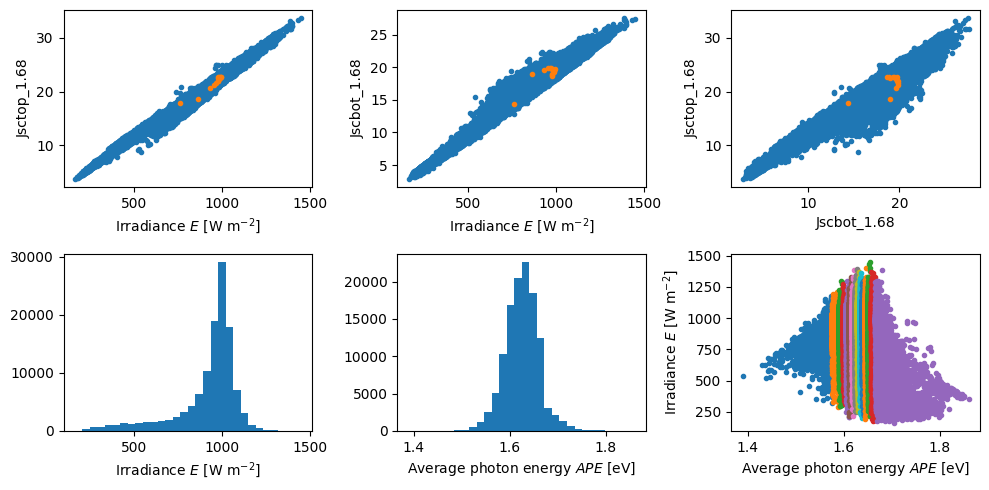

In [28]:
n_choose = 2
resampler = "1T"
fig, ax = plt.subplots(2,3, figsize=(10,5))
# ax[0].plot(currents.resample(resampler).mean().iloc[:, (2 * n_choose) + 1], currents.resample(resampler).mean().iloc[:, (2 * n_choose)], ".")
ax[0,0].plot(meteo_spectra_filtered.SpecPower, currents.iloc[:, (2 * n_choose)], ".")
ax[0,0].set_ylabel(currents.resample(resampler).mean().columns[(2 * n_choose)])
ax[0,0].set_xlabel("Irradiance $E$ [W m$^{-2}$]")

ax[0,1].plot(meteo_spectra_filtered.SpecPower, currents.iloc[:, (2 * n_choose) + 1], ".")
ax[0,1].set_ylabel(currents.resample(resampler).mean().columns[(2 * n_choose) + 1])
ax[0,1].set_xlabel("Irradiance $E$ [W m$^{-2}$]")

ax[0,2].plot(currents.resample(resampler).mean().iloc[:, (2 * n_choose) + 1], currents.resample(resampler).mean().iloc[:, (2 * n_choose)], ".")
ax[0,2].set_xlabel(currents.resample(resampler).mean().columns[(2 * n_choose) + 1])
ax[0,2].set_ylabel(currents.resample(resampler).mean().columns[(2 * n_choose)])


eta_missmatch_g = eta_missmatch.groupby(["Eg"])
group_names = list(eta_missmatch_g.groups.keys())
eta_group = eta_missmatch_g.get_group(group_names[n_choose])
ax[0,0].plot(eta_group["powerIn"], eta_group["psc_jscs"],".")
ax[0,1].plot(eta_group["powerIn"], eta_group["si_jscs"],".")
ax[0,2].plot(eta_group["si_jscs"], eta_group["psc_jscs"],".")

ax[1,0].hist(meteo_spectra_filtered.SpecPower,30)
ax[1,0].set_xlabel("Irradiance $E$ [W m$^{-2}$]")
ax[1,1].hist(meteo_spectra_filtered.average_photon_energy,30)
ax[1,1].set_xlabel("Average photon energy $APE$ [eV]")

for idx_ape in range(len(ape_bin_mids)):
    ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
    ax[1,2].plot(ape_dataframe[ape_bin_mask]["SpecPower"],".")
    
    
ax[1,2].set_xlabel("Average photon energy $APE$ [eV]")
ax[1,2].set_ylabel("Irradiance $E$ [W m$^{-2}$]")


plt.tight_layout()

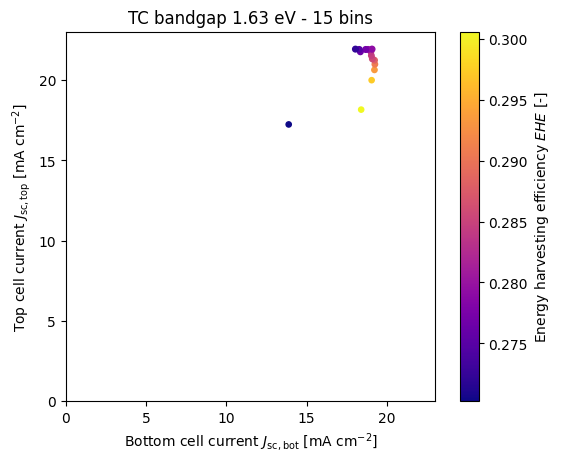

In [29]:
eta_missmatch_g = eta_missmatch.groupby(["Eg"])
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 1

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()

eta_group = eta_group[eta_group["binCount"] > 0]

# bin_energy = eta_group["bin_count"] * eta_group["powerIn"]
# scatter_size = (bin_energy - min(eta_group["bin_count"] * eta_group["powerIn"])) / max(eta_group["bin_count"] * eta_group["Pin"]) * 1500
# # scatter_size = (bin_energy - min(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"])) / max(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"]) * 1500

fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
sp = ax.scatter(
    eta_group["si_jscs"],
    eta_group["psc_jscs"],
    eta_group["temp"] * 2,
    # (eta_group["powerIn"] * eta_group["totalTime"])/5e5,
    (eta_group["power2Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    marker=".",
    cmap=cmap,
    # norm = "log",
    # vmin=0,
    # vmax = max_eta
)
plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")

# # current matches lines
# ax.plot([0, max_current], [0, max_current], "k--")
max_current = max(eta_group["si_jscs"].max(), eta_group["psc_jscs"].max())
# # limits
ax.set_xlim(0, 1.05 * max_current)
ax.set_ylim(0, 1.05 * max_current)
# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {eta_group.shape[0]} bins")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
# anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
ax.set_box_aspect(1)


In [30]:
with open("fullyear_global_163.p","rb") as fin:
    fy_data = pickle.load(fin)

In [31]:
ape_date_df = ape_dataframe.reset_index().rename(columns={"index":'ape'}).set_index('timestamps')
ape_date_df, _ = ape_date_df.align(fy_data,axis=0)

Text(0, 0.5, 'Top cell current $J_\\mathrm{sc,top}$ [mA cm$^{-2}$]')

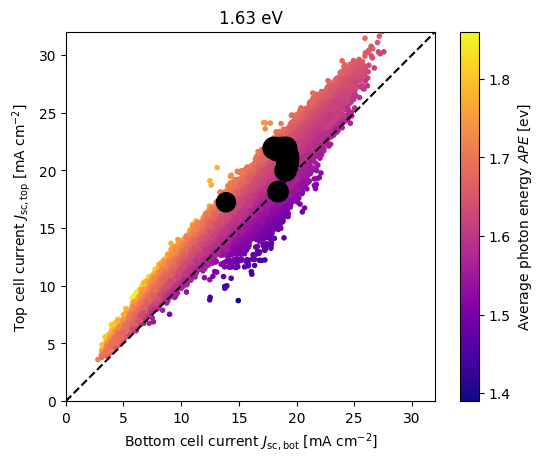

In [32]:
fig, ax = plt.subplots(1)

sp = ax.scatter(
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data["P2Tout"] / fy_data["Pin"] * 1e4, marker = '.', cmap = "plasma"
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data.index.hour, marker = '.', cmap = "plasma"
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data.index.hour * 60 + fy_data.index.minute, marker = '.', cmap = "plasma"
    fy_data["bottomcurrent"], fy_data["topcurrent"], None, ape_date_df.ape, marker = '.', cmap = "plasma",
    # vmin= 0.5,
    # vmax = 2
)
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Minute of the day [min]")
plt.colorbar(sp, ax=ax, orientation="vertical", label="Average photon energy $APE$ [ev]")

max_current = max(fy_data["bottomcurrent"].max(), fy_data["topcurrent"].max())

ax.plot([0, max_current], [0, max_current], "k--")


ax.scatter(
    eta_group["si_jscs"],
    eta_group["psc_jscs"],
    eta_group["powerIn"],
    # (eta_group["powerIn"] * eta_group["totalTime"])/5e5,
    # (eta_group["power2Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    'k',
    marker=".",
    # cmap=cmap,
    # norm = "log",
    # vmin= 0.5,
    # vmax = 2
)

# limits
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.set_box_aspect(1)

ax.set_title(f"{fy_data.Eg[0]} eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")


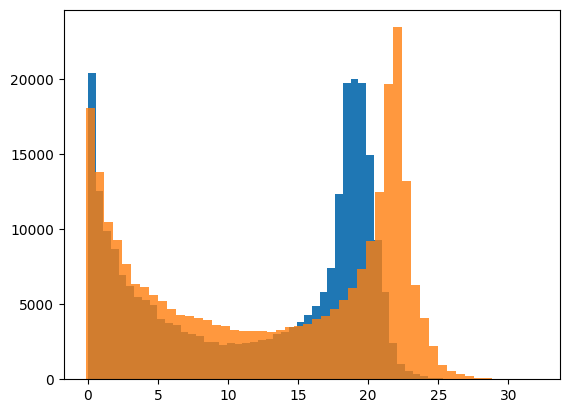

In [33]:
h= plt.hist(fy_data["bottomcurrent"],50)
h = plt.hist(fy_data["topcurrent"],50, alpha=0.8,)

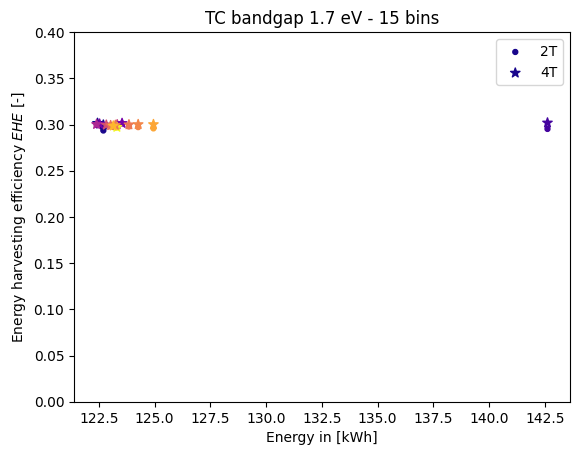

In [34]:
eta_missmatch_clean = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

eta_missmatch_g = eta_missmatch_clean.groupby(["Eg"])
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 3

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()

# bin_energy = eta_group["bin_count"] * eta_group["powerIn"]
# scatter_size = (bin_energy - min(eta_group["bin_count"] * eta_group["powerIn"])) / max(eta_group["bin_count"] * eta_group["Pin"]) * 1500
# # scatter_size = (bin_energy - min(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"])) / max(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"]) * 1500

fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
ax.scatter(
    (eta_group["powerIn"] * eta_group["totalTime"]) / 3600 / 1e3,
    (eta_group["power2Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    50,
    eta_group["temp"],
    marker = ".",
    label = "2T",
    cmap="plasma"
)

ax.scatter(
    (eta_group["powerIn"] * eta_group["totalTime"]) / 3600 / 1e3,
    (eta_group["power4Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    50,
    eta_group["temp"],
    marker = "*",
    label = "4T",
    cmap="plasma"
)


# # current matches lines
# ax.plot([0, max_current], [0, max_current], "k--")

# # limits
# ax.set_xlim(0, max_current)
ax.set_ylim(0,0.40)
# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {eta_group.shape[0]} bins")
ax.set_xlabel("Energy in [kWh]")
ax.set_ylabel("Energy harvesting efficiency $EHE$ [-]")
# anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)

ax.legend()


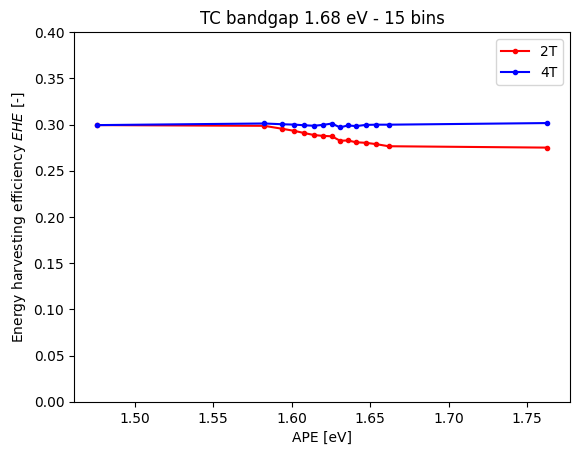

In [35]:
eta_missmatch_clean = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

eta_missmatch_g = eta_missmatch_clean.groupby(["Eg"])
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 2

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()


fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
# ax.scatter(
#     (eta_group["ape"]),
#     (eta_group["power2Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
#     50,
#     eta_group["temp"],
#     marker = ".",
#     label = "4T",
#     cmap="plasma"
# )

# ax.scatter(
#     (eta_group["ape"]),
#     (eta_group["power4Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
#     50,
#     eta_group["temp"],
#     marker = ".",
#     label = "4T",
#     cmap="plasma"
# )
ax.plot(
    (eta_group["ape"]),
    (eta_group["power2Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    marker = ".",
    c = "r",
    label = "2T",
)

ax.plot(
    (eta_group["ape"]),
    (eta_group["power4Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    marker = ".",
    c = "b",
    label = "4T",
)

# # limits
# ax.set_xlim(0, max_current)
ax.set_ylim(0,0.40)
# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {eta_group.shape[0]} bins")
ax.set_xlabel("APE [eV]")
ax.set_ylabel("Energy harvesting efficiency $EHE$ [-]")

ax.legend()


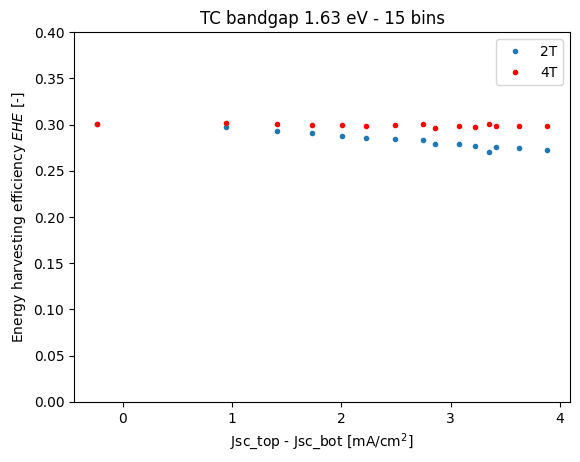

In [36]:
eta_missmatch_g = eta_missmatch.groupby(["Eg"])
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 1

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()


fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
ax.plot(
    (eta_group["psc_jscs"] - eta_group["si_jscs"]),
    (eta_group["power2Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    ".", label = "2T"
)

ax.plot(
    (eta_group["psc_jscs"] - eta_group["si_jscs"]),
    (eta_group["power4Tout"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    "r.", label = "4T"
)


# # limits
# ax.set_xlim(0, max_current)
ax.set_ylim(0,0.40)
# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {eta_group.shape[0]} bins")
ax.set_xlabel("Jsc_top - Jsc_bot [mA/cm$^2$]")
ax.set_ylabel("Energy harvesting efficiency $EHE$ [-]")

ax.legend()


(0.0, 2.5)

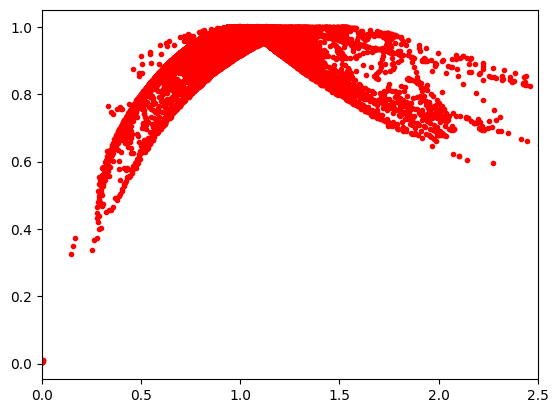

In [37]:
fig, ax = plt.subplots(1)
t_min = 20
t_max = 25
t_filter = (fy_data["Tcell"] > t_min) & (fy_data["Tcell"] < t_max)
fy_data_filterd = fy_data[t_filter]
# ax.plot(
#     fy_data_filterd["topcurrent"] - fy_data_filterd["bottomcurrent"], fy_data_filterd["P2Tout"] / fy_data_filterd["Pin"] * 1e4, "r."
# )
# ax.plot(
#     fy_data_filterd["topcurrent"] - fy_data_filterd["bottomcurrent"], fy_data_filterd["P4Tout"] / fy_data_filterd["Pin"] * 1e4, "bo", mfc='none'
# )
ax.plot(
    fy_data_filterd["topcurrent"] / fy_data_filterd["bottomcurrent"], fy_data_filterd["P2Tout"] / fy_data_filterd["P4Tout"], "r."
)
ax.set_xlim(0,2.5)
# ax.set_ylim(0, 1)


In [38]:
ape_date_df = ape_dataframe.reset_index().rename(columns={"index":'ape'}).set_index('timestamps')
_, ape_date_df = fy_data.align(ape_date_df)


Text(0, 0.5, 'Top cell current $J_\\mathrm{sc,top}$ [mA cm$^{-2}$]')

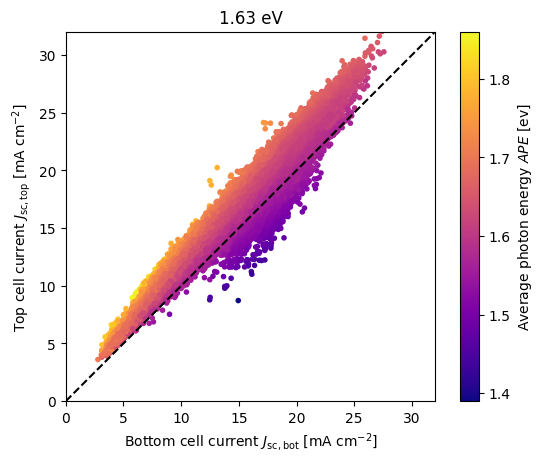

In [39]:
fig, ax = plt.subplots(1)

sp = ax.scatter(
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data["P2Tout"] / fy_data["Pin"] * 1e4, marker = '.', cmap = "plasma"
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data.index.hour, marker = '.', cmap = "plasma"
    # fy_data["bottomcurrent"], fy_data["topcurrent"], None, fy_data.index.hour * 60 + fy_data.index.minute, marker = '.', cmap = "plasma"
    fy_data["bottomcurrent"], fy_data["topcurrent"], None, ape_date_df.ape, marker = '.', cmap = "plasma"
)
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Minute of the day [min]")
plt.colorbar(sp, ax=ax, orientation="vertical", label="Average photon energy $APE$ [ev]")

max_current = max(fy_data["bottomcurrent"].max(), fy_data["topcurrent"].max())

ax.plot([0, max_current], [0, max_current], "k--")
# limits
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.set_box_aspect(1)

ax.set_title(f"{fy_data.Eg[0]} eV")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")


Text(0.5, 1.0, '1.63 eV')

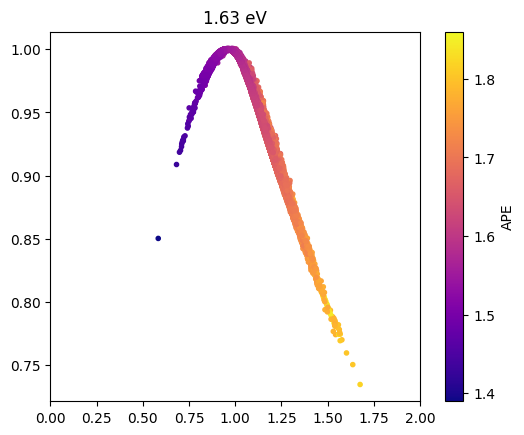

In [40]:
fig, ax = plt.subplots(1)

sp = ax.scatter(
    # fy_data["topcurrent"] / fy_data["bottomcurrent"], fy_data["P2Tout"] / fy_data["P4Tout"], None, fy_data.index.hour * 60 + fy_data.index.minute, marker = '.', cmap = "plasma"
    fy_data["topcurrent"] / fy_data["bottomcurrent"], fy_data["P2Tout"] / fy_data["P4Tout"], None, ape_date_df.ape, marker = '.', cmap = "plasma"
)
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")
# plt.colorbar(sp, ax=ax, orientation="vertical", label="Minute of the day [min]")
plt.colorbar(sp, ax=ax, orientation="vertical", label="APE")

max_current = max(fy_data["bottomcurrent"].max(), fy_data["topcurrent"].max())

# ax.plot([0, max_current], [0, max_current], "k--")
# limits
ax.set_box_aspect(1)
ax.set_xlim(0,2)
ax.set_title(f"{fy_data.Eg[0]} eV")
# ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
# ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")


Text(0.5, 1.0, '1.63 eV')

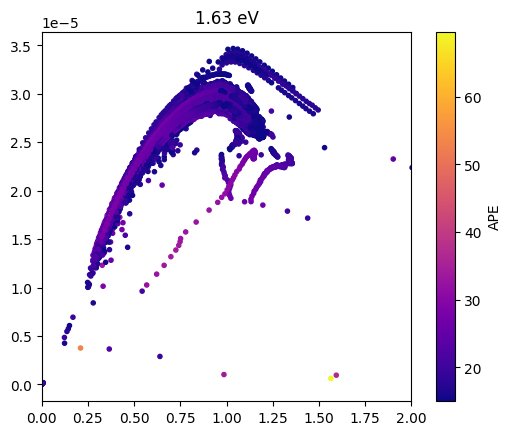

In [41]:
egs = list(fp_psk_eqe.keys())
n = 2
resampler = "1T"

_, meteo_sync = sync(fy_data, meteo_data.data)
dir_diff_ratio = meteo_sync["Direct CHP1-1 [W/m^2]"] / meteo_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
fy_data_filterd = fy_data[dir_diff_ratio>15]
dir_diff_ratio = dir_diff_ratio[dir_diff_ratio>15]

fig, ax = plt.subplots(1)

sp = ax.scatter(
    fy_data_filterd["topcurrent"] / fy_data_filterd["bottomcurrent"], fy_data_filterd["P2Tout"] / fy_data_filterd["Pin"], None, dir_diff_ratio, marker = '.', cmap = "plasma"
)
plt.colorbar(sp, ax=ax, orientation="vertical", label="APE")

max_current = max(fy_data["bottomcurrent"].max(), fy_data["topcurrent"].max())

ax.set_box_aspect(1)
ax.set_xlim(0,2)
ax.set_title(f"{fy_data.Eg[0]} eV")


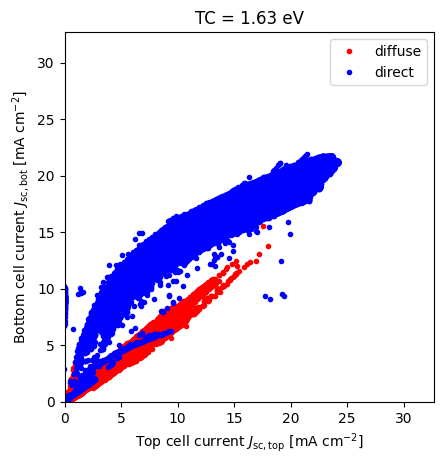

In [42]:
egs = list(fp_psk_eqe.keys())
n = 2
resampler = "1T"

_, meteo_sync = sync(fy_data, meteo_data.data)
dir_diff_ratio = meteo_sync["Direct CHP1-1 [W/m^2]"] / meteo_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
dir_diff_threshold = dir_diff_ratio.quantile(0.2)

fy_data_filterd = fy_data[dir_diff_ratio < dir_diff_threshold]
ape_filtered = ape_date_df.ape[dir_diff_ratio < dir_diff_threshold]

fig, ax = plt.subplots(1)

ax.plot(fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], "r.")  # None, ape_filtered, marker = '.', cmap = "plasma"


dir_diff_threshold = dir_diff_ratio.quantile(0.8)
fy_data_filterd = fy_data[dir_diff_ratio > dir_diff_threshold]
ape_filtered = ape_date_df.ape[dir_diff_ratio > dir_diff_threshold]

ax.plot(fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], "b.")

# sp = ax.scatter(
#     fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], None, ape_filtered, marker = '.', cmap = "plasma"
# )
max_current = max(fy_data["bottomcurrent"].max(), fy_data["topcurrent"].max()) * 1.02

ax.set_box_aspect(1)
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.set_title(f"TC = {fy_data.Eg[0]} eV")

ax.set_xlabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
ax.set_ylabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.legend(["diffuse", "direct"])

Text(0, 0.5, 'Bottom cell current $J_\\mathrm{sc,bot}$ [mA cm$^{-2}$]')

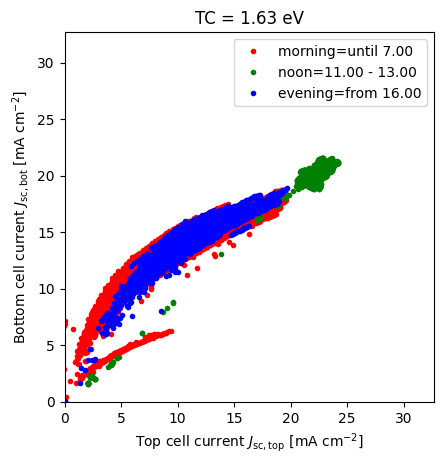

In [43]:
egs = list(fp_psk_eqe.keys())
n = 2
resampler = "1T"

morning = 7
morning_noon = 11
noon_evening = 13
evening = 16

dir_diff_threshold = dir_diff_ratio.quantile(0.8)

fig, ax = plt.subplots(1)

fy_data_filterd = fy_data[(fy_data.index.hour < morning) & (dir_diff_ratio > dir_diff_threshold)]
# fy_data_filterd = fy_data[(fy_data.index.hour < morning)]
ax.plot(fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], "r.")

fy_data_filterd = fy_data[(fy_data.index.hour > morning_noon) & (fy_data.index.hour < noon_evening) & (dir_diff_ratio > dir_diff_threshold)]
# fy_data_filterd = fy_data[(fy_data.index.hour > morning_noon) & (fy_data.index.hour < noon_evening)]
ax.plot(fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], "g.")

fy_data_filterd = fy_data[(fy_data.index.hour > evening) & (dir_diff_ratio > dir_diff_threshold)]
# fy_data_filterd = fy_data[(fy_data.index.hour > evening)]
ax.plot(fy_data_filterd["topcurrent"], fy_data_filterd["bottomcurrent"], "b.")


ax.set_box_aspect(1)
ax.set_xlim(0, max_current)
ax.set_ylim(0, max_current)
ax.set_title(f"TC = {fy_data.Eg[0]} eV")
ax.legend([f"morning=until {morning:.2f}", f"noon={morning_noon:.2f} - {noon_evening:.2f}", f"evening=from {evening:.2f}"])

ax.set_xlabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
ax.set_ylabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")


Try single day / month

In [75]:
_, meteo_sync = sync(fy_data, meteo_data.data)
dir_diff_ratio = meteo_sync["Direct CHP1-1 [W/m^2]"] / meteo_sync["Diffuse CM22-1 (vent/cor) [W/m^2]"]
dir_diff_threshold = dir_diff_ratio.quantile(0.8)
dir_filter = dir_diff_ratio > dir_diff_threshold

dir_diff_threshold = dir_diff_ratio.quantile(0.2)
diff_filter = dir_diff_ratio < dir_diff_threshold



fy_data_filterd = fy_data[dir_filter]
fy_data_filterd = fy_data[dir_filter]

month_filter = (meteo_spectra.spectra.index.month >= 0)# & (meteo_spectra.spectra.index.day == 6)
# month_filter = dir_filter
# month_filter = diff_filter


fy_data_filterd = fy_data[month_filter]
meteo_spectra_filtered = meteo_spectra.filter_custom(month_filter)
ape_dataframe = get_ape_df(meteo_spectra_filtered)


In [45]:
# energy weigh temperatures
# ape_dataframe["TempCell"] = ape_dataframe["TempCell"] * ape_dataframe["SpecPower"] / ape_dataframe["SpecPower"].sum()

In [62]:
# egs = egs[1]
egs = [1.63]

In [76]:
nr_of_ape_bins = [5, 10, 30]
nr_of_temp_bins = [2,5]
eg_choose = 1

cols = [
    "Eg",
    "NrOfApeBins",
    "NrOfTempBins",
    "totalTime",
    "binCount",
    "ape",
    "temp",
    "ape_bin_width",
    "temp_bin_width",
    "powerIn",
    "power2Tout",
    "power4Tout",
    "psc_jscs",
    "si_jscs",
]

eta_missmatch = pd.DataFrame(np.zeros([np.sum(nr_of_ape_bins) * np.sum(nr_of_temp_bins) * len(egs), len(cols)]), columns=cols)
row_counter = 0

for ape_bin_nr in nr_of_ape_bins:
    ape_bin_mids, ape_bin_edges, ape_bin_counts = ape_binning(nr_of_ape_bins=ape_bin_nr,ape_dataframe=ape_dataframe)

    egs = list(fp_psk_eqe.keys())



    assert (ape_dataframe["timestamps"] == meteo_spectra_filtered.spectra.index).all()

    ape_spectra = pd.DataFrame(
        np.zeros([len(ape_bin_mids), len(meteo_spectra_filtered.wavelength)]), index=ape_bin_mids, columns=meteo_spectra_filtered.wavelength
    )
    irradiance = []
    total_bin_energy = []
    for idx_ape in trange(len(ape_bin_mids)):
        # get a mask for the current APE bin range
        ape_bin_mask = (ape_dataframe.index > ape_bin_edges[idx_ape]) & (ape_dataframe.index <= ape_bin_edges[idx_ape + 1])
        # filter the spectra with this mask to get all spectra for this APE range
        bin_spectra = meteo_spectra_filtered.spectra[ape_bin_mask]

        # get the timestamps and determine time deltas for each spectra
        bin_times = bin_spectra.index
        bin_time_deltas = bin_times.to_series().diff().astype(np.int64) / 1e9
        _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
        # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
        bin_time_deltas[day_idx] = 60

        # set all to 60s
        bin_time_deltas[:] = 60

        # weight all spectra with the time and divide by total time to get averaged spectra
        ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1, 1)) / np.sum(bin_time_deltas)

        # weight all spectra with the energy and divide by total energy to get averaged spectra
        bin_irradiances = pd.Series(np.trapz(x=bin_spectra.columns.astype(np.float32), y=bin_spectra), index=bin_spectra.index)
        bin_energies = bin_irradiances * bin_time_deltas
        total_bin_energy.append(np.sum(bin_energies))

        # ape_spectra.iloc[idx_ape, :] = np.sum(bin_spectra * bin_energies.values.reshape(-1, 1)) / np.sum(bin_energies)

        irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx_ape, :]))

        # bin temperature in each bin
        apebin_temps = ape_dataframe[ape_bin_mask]
              
        # nr_of_temp_bins = len(apebin_temps)

        for temp_bin_nr in nr_of_temp_bins:
            bin_temps = pd.cut(apebin_temps["TempCell"], bins=temp_bin_nr, include_lowest=True)
            bin_temps_unique = bin_temps.value_counts()
            # bin_temps_unique = bin_temps_unique[bin_temps_unique != 0]
            for bin_temp in bin_temps_unique.index:
                bin_temp_mask = bin_temps == bin_temp

                if not any(bin_temp_mask):
                    warnings.warn("Empty temperature mask")
                    eta_missmatch.iloc[row_counter, :] = np.nan
                    # raise("Empty temperature mask")

                bin_temp_times = bin_time_deltas[bin_temp_mask.values]

                for id_eg in range(len(egs)):
                    eg = egs[id_eg]
                    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
                    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
                    # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
                    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
                    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

                    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
                    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

                    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
                    egs_si = si_eg_shift(bin_temp.mid, eg_si)
                    sigmas_si = si_sigma_shift(bin_temp.mid, sigma_si)

                    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
                    egs_psc = psc_eg_shift(bin_temp.mid, eg_psc)
                    sigmas_psc = psc_sigma_shift(bin_temp.mid, sigma_psc)

                    si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], ape_spectra.iloc[idx_ape, :])
                    psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], ape_spectra.iloc[idx_ape, :])

                    eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
                    lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

                    EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
                    EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

                    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)

                    powerIn = np.trapz(x=ape_spectra.columns, y=ape_spectra.iloc[idx_ape, :])

                    dev3T.top.set(Jext=np.round(psc_jscs, 3) / 1e3, TC=bin_temp.mid, Eg=egs_psc)
                    dev3T.bot.set(Jext=np.round(si_jscs, 3) / 1e3, TC=bin_temp.mid, Eg=egs_si)

                    _, iv3t = dev3T.CM()
                    power2T = iv3t.Ptot[0]
                    iv3t = dev3T.MPP()
                    power4T = iv3t.Ptot[0]

                    eta_missmatch.at[row_counter, "Eg"] = eg
                    eta_missmatch.at[row_counter, "NrOfApeBins"] = ape_bin_nr
                    eta_missmatch.at[row_counter, "NrOfTempBins"] = temp_bin_nr
                    eta_missmatch.at[row_counter, "totalTime"] = np.sum(bin_temp_times)
                    eta_missmatch.at[row_counter, "binCount"] = bin_temps_unique[bin_temp]
                    eta_missmatch.at[row_counter, "ape"] = ape_bin_mids[idx_ape]
                    eta_missmatch.at[row_counter, "temp"] = bin_temp.mid
                    eta_missmatch.at[row_counter, "ape_bin_width"] = ape_bin_edges[idx_ape + 1] - ape_bin_edges[idx_ape]
                    eta_missmatch.at[row_counter, "temp_bin_width"] = bin_temp
                    eta_missmatch.at[row_counter, "powerIn"] = powerIn
                    eta_missmatch.at[row_counter, "power2Tout"] = power2T
                    eta_missmatch.at[row_counter, "power4Tout"] = power4T
                    eta_missmatch.at[row_counter, "psc_jscs"] = psc_jscs
                    eta_missmatch.at[row_counter, "si_jscs"] = si_jscs
                    row_counter += 1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [77]:
eta_missmatch["energy2T"] = (eta_missmatch["power2Tout"] * eta_missmatch["totalTime"] / 60) # totalTime is in seconds
bin_energy_yield = eta_missmatch.groupby(["Eg","NrOfApeBins", "NrOfTempBins"]).sum(numeric_only=True)["energy2T"].unstack()
# bin_energy_yield = bin_energy_yield.set_index(bin_energy_yield.index * bin_energy_yield.columns)

In [79]:
full_energy_yield = fy_data["P2Tout"].loc[meteo_spectra_filtered.spectra.index].sum()  # Time is in minutes.

In [80]:
(bin_energy_yield.loc[1.63]/full_energy_yield  - 1) * 100


NrOfTempBins,2.0,5.0
NrOfApeBins,,
5.0,0.137131,0.063746
10.0,0.023641,-0.073985
30.0,-0.018835,-0.197367


Text(0, 0.5, 'Deviation bin vs full year [%]')

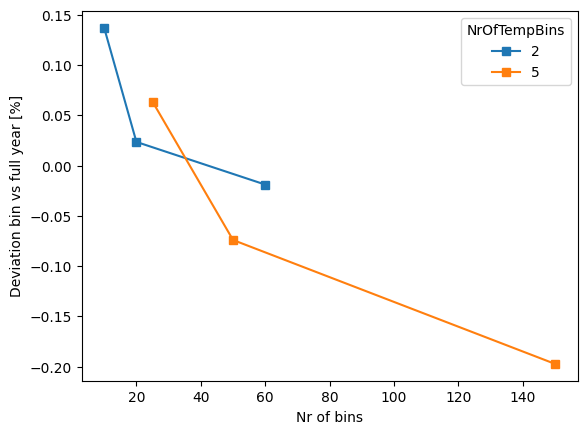

In [81]:
plt.plot(bin_energy_yield.loc[1.63].index.values.reshape(-1,1) * bin_energy_yield.columns.values,(bin_energy_yield.loc[1.63]/full_energy_yield  - 1) * 100, "-s")
# plt.plot(np.array(nr_of_ape_bins) * np.array(nr_of_temp_bins), (ehe_bins/ehe_full - 1) * 100, "-s")
plt.legend(bin_energy_yield.columns.astype(int), title=bin_energy_yield.columns.name)
plt.xlabel("Nr of bins")
plt.ylabel("Deviation bin vs full year [%]")

In [ ]:
#filter a particular day and compare the power with fy_data
day2filter = meteo_spectra.spectra.index[223]

dayfilter = meteo_spectra.spectra.index == day2filter
fy_data_filterd = fy_data[dayfilter]

meteo_spectra_filtered = meteo_spectra.filter_custom(dayfilter)

In [ ]:
cols = [
    "Eg",
    "totalTime",
    "binCount",
    "ape",
    "temp",
    "ape_bin_width",
    "temp_bin_width",
    "powerIn",
    "power2Tout",
    "power4Tout",
    "psc_jscs",
    "si_jscs",
]

eta_missmatch = pd.DataFrame(np.zeros([len(egs) * ape_bin_nr * nr_of_temp_bins, len(cols)]), columns=cols)

row_counter = 0


for id_eg in range(len(egs)):
    eg = egs[id_eg]
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_spectra_filtered.spectra = match_eqe_spectra(df_tandem_eqe, meteo_spectra_filtered.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    egs_si = si_eg_shift(meteo_spectra_filtered.TempCell, eg_si)
    sigmas_si = si_sigma_shift(meteo_spectra_filtered.TempCell, sigma_si)

    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    egs_psc = psc_eg_shift(meteo_spectra_filtered.TempCell, eg_psc)
    sigmas_psc = psc_sigma_shift(meteo_spectra_filtered.TempCell, sigma_psc)

    si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], meteo_spectra_filtered.spectra)
    psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], meteo_spectra_filtered.spectra)

    eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
    lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

    EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
    EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)

    powerIn = np.trapz(x=meteo_spectra_filtered.wavelength, y=meteo_spectra_filtered.spectra)

    dev3T.top.set(Jext=np.round(psc_jscs, 3) / 1e3, TC=meteo_spectra_filtered.TempCell, Eg=egs_psc)
    dev3T.bot.set(Jext=np.round(si_jscs, 3) / 1e3, TC=meteo_spectra_filtered.TempCell, Eg=egs_si)

    _, iv3t = dev3T.CM()
    power2T = iv3t.Ptot[0]
    iv3t = dev3T.MPP()
    power4T = iv3t.Ptot[0]

    eta_missmatch.at[row_counter, "Eg"] = eg
    eta_missmatch.at[row_counter, "totalTime"] = np.sum(bin_temp_times)
    eta_missmatch.at[row_counter, "binCount"] = bin_temps_unique[bin_temp]
    eta_missmatch.at[row_counter, "ape"] = ape_bin_mids[idx_ape]
    eta_missmatch.at[row_counter, "temp"] = bin_temp.mid
    eta_missmatch.at[row_counter, "ape_bin_width"] = ape_bin_edges[idx_ape + 1] - ape_bin_edges[idx_ape]
    eta_missmatch.at[row_counter, "temp_bin_width"] = bin_temp
    eta_missmatch.at[row_counter, "powerIn"] = powerIn
    eta_missmatch.at[row_counter, "power2Tout"] = power2T
    eta_missmatch.at[row_counter, "power4Tout"] = power4T
    eta_missmatch.at[row_counter, "psc_jscs"] = psc_jscs
    eta_missmatch.at[row_counter, "si_jscs"] = si_jscs
    row_counter += 1



eta_missmatch



,Eg,totalTime,binCount,ape,temp,ape_bin_width,temp_bin_width,powerIn,power2Tout,power4Tout,psc_jscs,si_jscs
0,1.25,60.0,1.0,1.899069,19.268,0.165251,"(19.223, 19.313]",53.595606,0.000287,0.001163,1.891800,0.308590
1,1.63,60.0,1.0,1.899069,19.268,0.165251,"(19.223, 19.313]",53.595606,0.001337,0.001406,1.289687,1.003067
2,1.68,60.0,1.0,1.899069,19.268,0.165251,"(19.223, 19.313]",53.595606,0.001312,0.001325,1.342396,1.039167
3,1.70,60.0,1.0,1.899069,19.268,0.165251,"(19.223, 19.313]",53.595606,0.001502,0.001566,1.221970,1.110792
4,1.75,60.0,1.0,1.899069,19.268,0.165251,"(19.223, 19.313]",53.595606,0.001613,0.001619,1.140765,1.181606
...,...,...,...,...,...,...,...,...,...,...,...,...
37795,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
37796,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
37797,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
37798,0.00,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
